In [1]:
import numpy as np
import awkward as ak
import hist
import warnings
import pickle
from coffea.ml_tools.torch_wrapper import torch_wrapper
import matplotlib.pyplot as plt
import hist
from sklearn.metrics import roc_curve, auc
import math
import os
import uproot
import json
from utility_functions2 import *
import pandas as pd
import pyarrow as pa

In [2]:
warnings.filterwarnings('ignore', 'No format checks')

In [3]:
msd_up = 200
msd_down = 40
pt_up = 600
pt_down = 450

In [4]:
#use = 'hbb'
use = 'hgg'
if use == 'hgg':
    signal, model1, model2, scaler1, scaler2 = signal_read_in('hgg', msd_up, msd_down, pt_up, pt_down)
else:
    signal, model, scaler = signal_read_in('hbb', msd_up, msd_down, pt_up, pt_down)

temp_dict = {}
for k in signal.fields:
    temp_dict[k] = signal[k].to_numpy()
nan_dict = {}
for l in temp_dict:
    nan_mask = ~np.isnan(temp_dict[l])
    nan_dict[l] = nan_mask
nanless = {}
for l in signal.fields:
    nanless[l] = temp_dict[l][nan_dict[l]]
sizes = []
for l in nanless:
    sizes.append(len(nanless[l]))

losses = [(x - min(sizes)) for x in sizes]
for l in nanless:
    nanless[l] = nanless[l][:min(sizes)]
temp = pd.DataFrame.from_dict(nanless)
signal = ak.from_arrow(pa.Table.from_pandas(temp))

signal['mratio'] = signal.mass/signal.msoftdrop

In [5]:
qcd = ['qcd_300to470', 'qcd_470to600', 'qcd_600to800', 'qcd_800to1000', 'qcd_1000to1400',
       'qcd_1400to1800', 'qcd_1800to2400', 'qcd_2400to3200', 'qcd_3200toInf']
ttboosted = ['ttboosted_700to1000', 'ttboosted_1000toInf']
wqq = ['wqq_600to800', 'wqq_800toInf']
zqq = ['zqq_600to800', 'zqq_800toInf']

In [6]:
bkg_dict = {}
bkg_dict['qcd'] = bkg_read_in('qcd', msd_up, msd_down, pt_up, pt_down)
bkg_dict['ttboosted'] = bkg_read_in('ttboosted', msd_up, msd_down, pt_up, pt_down)
bkg_dict['wqq'] = bkg_read_in('wqq', msd_up, msd_down, pt_up, pt_down)
bkg_dict['zqq'] = bkg_read_in('zqq', msd_up, msd_down, pt_up, pt_down)
bkg_dict['singletop'] = bkg_read_in('singletop', msd_up, msd_down, pt_up, pt_down)
bkg_dict['ww'] = bkg_read_in('ww', msd_up, msd_down, pt_up, pt_down)
bkg_dict['wz'] = bkg_read_in('wz', msd_up, msd_down, pt_up, pt_down)
bkg_dict['zz'] = bkg_read_in('zz', msd_up, msd_down, pt_up, pt_down)
bkg_dict['ww4q'] = bkg_read_in('ww4q', msd_up, msd_down, pt_up, pt_down)
if use == 'hgg':
    bkg_dict['hbb'] = bkg_read_in('hbb', msd_up, msd_down, pt_up, pt_down)

for i in bkg_dict:
    bkg_dict[i]['mratio'] = bkg_dict[i].mass/bkg_dict[i].msoftdrop

In [7]:
# bkg_dict = {}
# bkg_dict['qcd'] = {}
# for i in qcd:
#     bkg_dict['qcd'][i] = bkg_read_in(i, msd_up, msd_down, pt_up, pt_down)
#     bkg_dict['qcd'][i]['mratio'] = bkg_dict['qcd'][i].mass/bkg_dict['qcd'][i].msoftdrop
# bkg_dict['ttboosted'] = {}
# for i in ttboosted:
#     bkg_dict['ttboosted'][i] = bkg_read_in(i, msd_up, msd_down, pt_up, pt_down)
#     bkg_dict['ttboosted'][i]['mratio'] = bkg_dict['ttboosted'][i].mass/bkg_dict['ttboosted'][i].msoftdrop
# bkg_dict['wqq'] = {}
# for i in wqq:
#     bkg_dict['wqq'][i] = bkg_read_in(i, msd_up, msd_down, pt_up, pt_down)
#     bkg_dict['wqq'][i]['mratio'] = bkg_dict['wqq'][i].mass/bkg_dict['wqq'][i].msoftdrop
# bkg_dict['zqq'] = {}
# for i in zqq:
#     bkg_dict['zqq'][i] = bkg_read_in(i, msd_up, msd_down, pt_up, pt_down)
#     bkg_dict['zqq'][i]['mratio'] = bkg_dict['zqq'][i].mass/bkg_dict['zqq'][i].msoftdrop
# bkg_dict['singletop'] = bkg_read_in('singletop', msd_up, msd_down, pt_up, pt_down)
# bkg_dict['singletop']['mratio'] = bkg_dict['singletop'].mass/bkg_dict['singletop'].msoftdrop
# bkg_dict['ww'] = bkg_read_in('ww', msd_up, msd_down, pt_up, pt_down)
# bkg_dict['ww']['mratio'] = bkg_dict['ww'].mass/bkg_dict['ww'].msoftdrop
# bkg_dict['wz'] = bkg_read_in('wz', msd_up, msd_down, pt_up, pt_down)
# bkg_dict['wz']['mratio'] = bkg_dict['wz'].mass/bkg_dict['wz'].msoftdrop
# bkg_dict['zz'] = bkg_read_in('zz', msd_up, msd_down, pt_up, pt_down)
# bkg_dict['zz']['mratio'] = bkg_dict['zz'].mass/bkg_dict['zz'].msoftdrop
# #bkg_dict['ww4q'] = bkg_read_in('ww4q', msd_up, msd_down, pt_up, pt_down)
# if use == 'hgg':
#     bkg_dict['hbb'] = bkg_read_in('hbb', msd_up, msd_down, pt_up, pt_down)
#     bkg_dict['hbb']['mratio'] = bkg_dict['hbb'].mass/bkg_dict['hbb'].msoftdrop

In [8]:
for i in bkg_dict:
    if type(bkg_dict[i]) == dict:
        for j in bkg_dict[i]:
            temp_dict = {}
            for k in bkg_dict[i][j].fields:
                temp_dict[k] = bkg_dict[i][j][k].to_numpy()
            nan_dict = {}
            for l in temp_dict:
                nan_mask = ~np.isnan(temp_dict[l])
                nan_dict[l] = nan_mask
            nanless = {}
            for l in bkg_dict[i][j].fields:
               nanless[l] = temp_dict[l][nan_dict[l]]
            sizes = []
            for l in nanless:
                sizes.append(len(nanless[l]))
            
            losses = [(x - min(sizes)) for x in sizes]
            for l in nanless:
                nanless[l] = nanless[l][:min(sizes)]
            temp = pd.DataFrame.from_dict(nanless)
            bkg_dict[i][j] = ak.from_arrow(pa.Table.from_pandas(temp))
    else:
        temp_dict = {}
        for k in bkg_dict[i].fields:
            temp_dict[k] = bkg_dict[i][k].to_numpy()
        nan_dict = {}
        for l in temp_dict:
            nan_mask = ~np.isnan(temp_dict[l])
            nan_dict[l] = nan_mask
        nanless = {}
        for l in bkg_dict[i].fields:
            nanless[l] = temp_dict[l][nan_dict[l]]
        sizes = []
        for l in nanless:
            sizes.append(len(nanless[l]))
        
        losses = [(x - min(sizes)) for x in sizes]
        for l in nanless:
            nanless[l] = nanless[l][:min(sizes)]
        temp = pd.DataFrame.from_dict(nanless)
        bkg_dict[i] = ak.from_arrow(pa.Table.from_pandas(temp))

In [9]:
# for i in bkg_dict:
#     if type(bkg_dict[i]) == dict:
#         for j in bkg_dict[i]:
#             bkg_dict[i][j] = bkg_dict[i][j][~ak.is_none(ak.nan_to_none(bkg_dict[i][j].n4))]
#             # a = len(bkg_dict[i][j])
#             #bkg_dict[i][j] = bkg_dict[i][j][~ak.is_none(bkg_dict[i][j].color_ring)]
#             # b = len(bkg_dict[i][j])
#             # print(f'{j} loss is {a-b}, this is {((a-b)/a)*100}%')
#     else:
#         bkg_dict[i] = bkg_dict[i][~ak.is_none(ak.nan_to_none(bkg_dict[i].n4))]
#         # a = len(bkg_dict[i])
#         #bkg_dict[i] = bkg_dict[i][~ak.is_none(bkg_dict[i].color_ring)]
#         # b = len(bkg_dict[i])
#         # print(f'{i} loss is {a-b}, this is {((a-b)/a)*100}%')

In [10]:
class EnergyCorrelatorFunctionTagger(torch_wrapper):
    def prepare_awkward(self, events, scaler):
        fatjets = events

        imap = {
            'vars': {
                # 'n2b1': fatjets.n2b1,
                # 'n3b1': fatjets.n3b1,
                # 'nConstituents': fatjets.nConstituents,
                'color_ring': fatjets.color_ring,
                'd2b1': fatjets.d2b1,
                # 'u1': fatjets.u1,
                # 'u2': fatjets.u2,
                # 'u3': fatjets.u3,
                'd3': fatjets.d3,
                'm2': fatjets.m2,
                'm3': fatjets.m3,
                'n4': fatjets.n4,
                # 'mratio': fatjets.mratio,
            },
        }

        retmap = {
            k: ak.concatenate([x[:, np.newaxis] for x in imap[k].values()], axis=1)
            for k in imap.keys()
        }
        x = ak.values_astype(scaler.transform(retmap['vars']), "float32")
        return (x,), {}

In [29]:
taggers = {}
taggers['qt'] = EnergyCorrelatorFunctionTagger(model1)
taggers['dt'] = EnergyCorrelatorFunctionTagger(model2)
# taggers['ht'] = EnergyCorrelatorFunctionTagger(model3)
# taggers['st'] = EnergyCorrelatorFunctionTagger(model4)
tagger_names = list(taggers.keys())

scalers = {}
scalers['qcd_scaler'] = scaler1
scalers['diboson_scaler'] = scaler2
# scalers['hbb_scaler'] = scaler3
# scalers['singletop_tagger'] = scaler4
scaler_names = list(scalers.keys())

In [30]:
def tagger_scores(sample):
    scores = {}
    for i in range(len(taggers)):
        scores[tagger_names[i]] = taggers[tagger_names[i]](sample, scalers[scaler_names[i]])[:,0]
    return scores

In [31]:
scores = {}
scores['signal'] = tagger_scores(signal)

for i in bkg_dict:
    scores[i] = {}
    if type(bkg_dict[i]) == dict:
        for j in bkg_dict[i]:
            scores[i][j] = {}
            scores[i][j] = tagger_scores(bkg_dict[i][j])
    else:
        scores[i] = tagger_scores(bkg_dict[i])

In [32]:
tagger = 'qt'

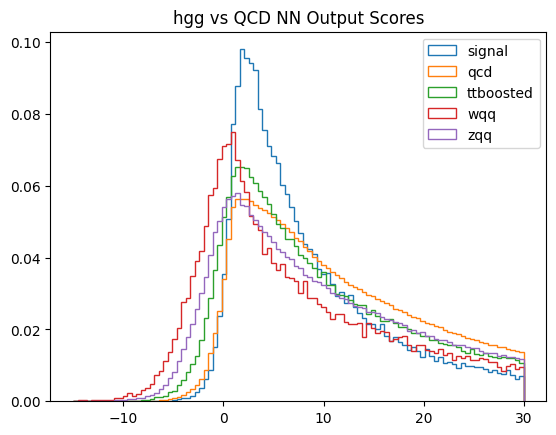

In [15]:
pltrange = (-15, 30)
score_plotter(scores['signal'][f'{tagger}'], 'signal', pltrange)
score_plotter(scores['qcd'][f'{tagger}'], 'qcd', pltrange)
score_plotter(scores['ttboosted'][f'{tagger}'], 'ttboosted', pltrange)
score_plotter(scores['wqq'][f'{tagger}'], 'wqq', pltrange)
score_plotter(scores['zqq'][f'{tagger}'], 'zqq', pltrange)
plt.title(f'{use} vs QCD NN Output Scores')
plt.legend()
plt.show()

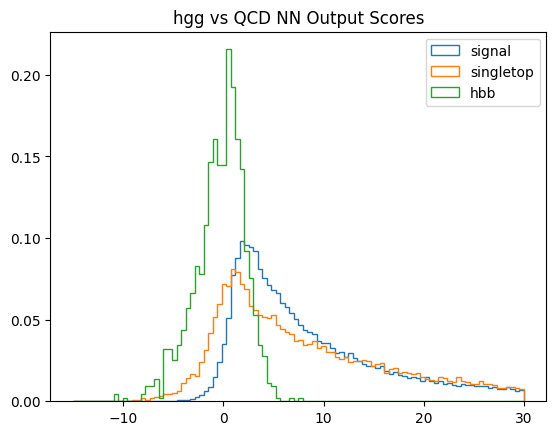

In [16]:
pltrange = (-15, 30)
score_plotter(scores['signal'][f'{tagger}'], 'signal', pltrange)
score_plotter(scores['singletop'][f'{tagger}'], 'singletop', pltrange)
score_plotter(scores['hbb'][f'{tagger}'], 'hbb', pltrange)
plt.title(f'{use} vs QCD NN Output Scores')
plt.legend()
plt.show()

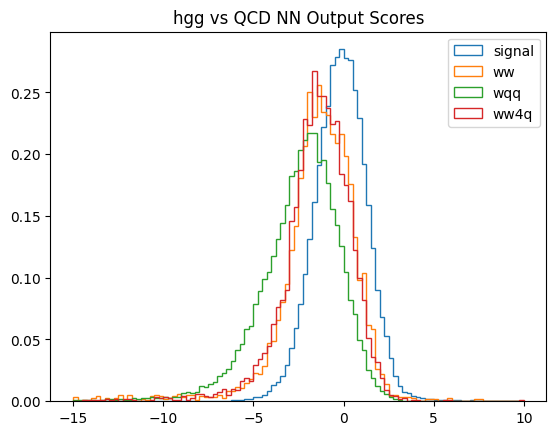

In [35]:
pltrange = (-15, 10)
score_plotter(scores['signal'][f'{tagger}'], 'signal', pltrange)
score_plotter(scores['ww'][f'{tagger}'], 'ww', pltrange)
score_plotter(scores['wqq'][f'{tagger}'], 'wqq', pltrange)
score_plotter(scores['ww4q'][f'{tagger}'], 'ww4q', pltrange)
# score_plotter(scores['wz'][f'{tagger}'], 'wz', pltrange)
# score_plotter(scores['zz'][f'{tagger}'], 'zz', pltrange)
plt.title(f'{use} vs QCD NN Output Scores')
plt.legend()
plt.show()

In [18]:
qcd_hist = make_hist('qcd', scores['qcd'][f'{tagger}'])
hgg_hist = make_hist('hgg', scores['signal'][f'{tagger}'])

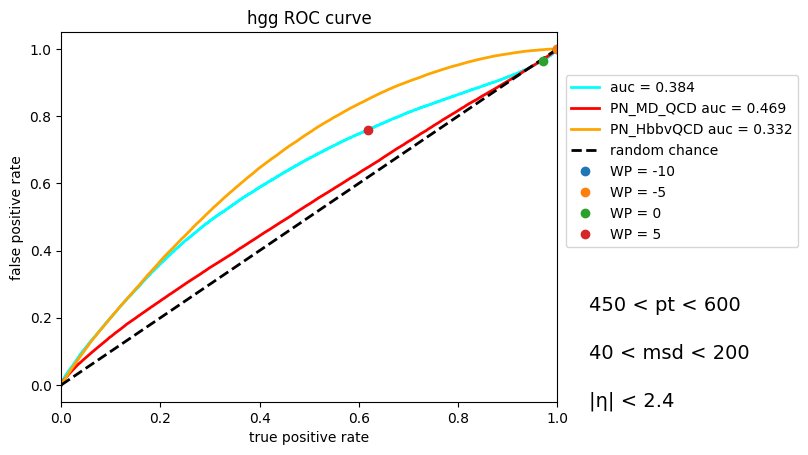

In [19]:
roc_maker(signal, bkg_dict['qcd'], hgg_hist, qcd_hist, scores['signal'][f'{tagger}'], 
          scores['qcd'][f'{tagger}'], use, pt_up, pt_down, msd_up, msd_down, True)

In [20]:
ww_hist = make_hist('ww', scores['ww'][f'{tagger}'])
hgg_hist = make_hist('hgg', scores['signal'][f'{tagger}'])

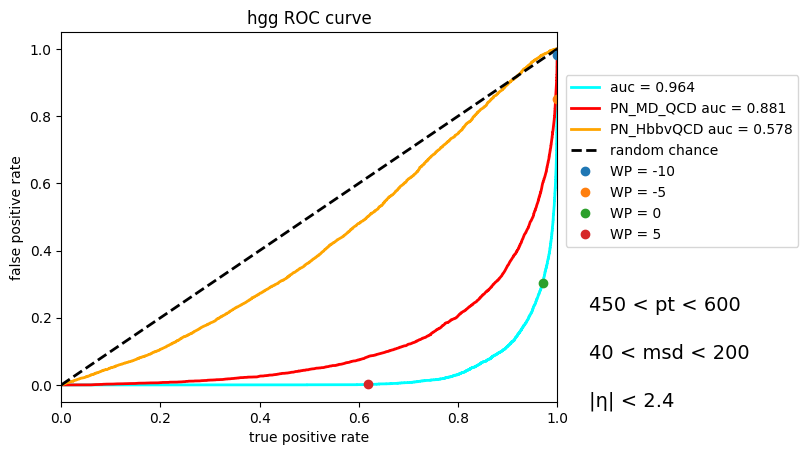

In [21]:
roc_maker(signal, bkg_dict['ww'], hgg_hist, ww_hist, scores['signal'][f'{tagger}'], 
          scores['ww'][f'{tagger}'], use, pt_up, pt_down, msd_up, msd_down, True)

In [22]:
zqq_hist = make_hist('zqq', scores['zqq'][f'{tagger}'])
hgg_hist = make_hist('hgg', scores['signal'][f'{tagger}'])

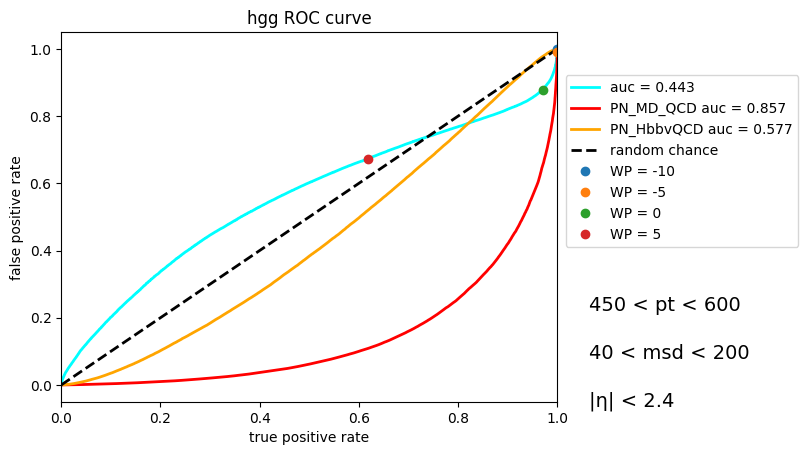

In [23]:
roc_maker(signal, bkg_dict['zqq'], hgg_hist, zqq_hist, scores['signal'][f'{tagger}'], 
          scores['zqq'][f'{tagger}'], use, pt_up, pt_down, msd_up, msd_down, True)

In [24]:
singletop_hist = make_hist('singletop', scores['singletop'][f'{tagger}'])
hgg_hist = make_hist('hgg', scores['signal'][f'{tagger}'])

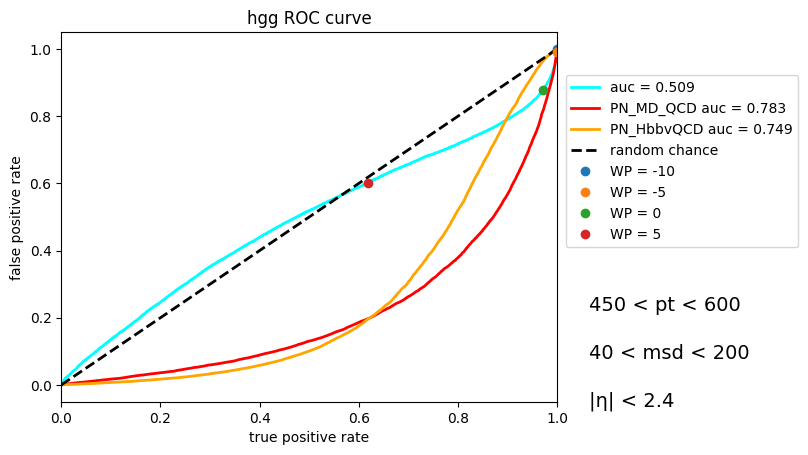

In [25]:
roc_maker(signal, bkg_dict['singletop'], hgg_hist, singletop_hist, scores['signal'][f'{tagger}'], 
          scores['singletop'][f'{tagger}'], use, pt_up, pt_down, msd_up, msd_down, True)

In [26]:
hbb_hist = make_hist('hbb', scores['hbb'][f'{tagger}'])
hgg_hist = make_hist('hgg', scores['signal'][f'{tagger}'])

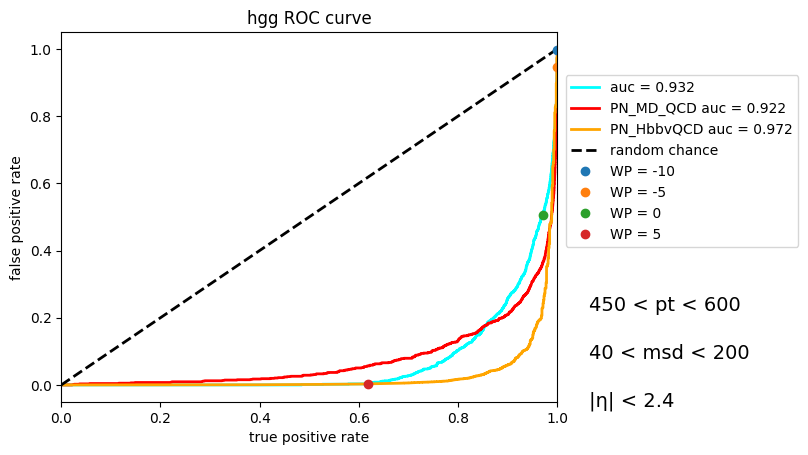

In [27]:
roc_maker(signal, bkg_dict['hbb'], hgg_hist, hbb_hist, scores['signal'][f'{tagger}'], 
          scores['hbb'][f'{tagger}'], use, pt_up, pt_down, msd_up, msd_down, True)